## Анализ исходных данных пользовательских действий

## Структура данных

In [1]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/Обучение Zerocoder Data Scientist/Final project/data_raw.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27756048 entries, 0 to 27756047
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Unnamed: 0  int64 
 1   client_id   int64 
 2   dt          object
 3   event_type  object
dtypes: int64(2), object(2)
memory usage: 847.0+ MB


In [2]:
df.head()

,Unnamed: 0,client_id,dt,event_type
0,0,6095092,2024-06-20,clicks
1,1,541138559,2024-06-18,clicks
2,2,12189072,2024-06-20,clicks
3,3,674385020,2024-06-20,clicks
4,4,726939378,2024-06-20,clicks


In [3]:
df['event_type'].unique()

array(['clicks', 'adds', 'views'], dtype=object)

In [4]:
df.describe()

,Unnamed: 0,client_id
count,2.775605e+07,2.775605e+07
mean,1.387802e+07,4.065550e+08
std,8.012481e+06,3.717998e+08
min,0.000000e+00,1.000000e+00
25%,6.939012e+06,1.124477e+07
50%,1.387802e+07,5.414179e+08
75%,2.081704e+07,6.936557e+08
max,2.775605e+07,9.579583e+08


### Проверка на дубликаты

In [5]:
duplicates_count = df.duplicated().sum()

if duplicates_count > 0:
    print(f'Количество дубликатов: {duplicates_count}')
else:
    print('Дубликаты отсутствуют')

Дубликаты отсутствуют


### Проверка на пропуски

In [6]:
# Проверка пропусков
missing = df.isnull().sum()
if missing.sum() == 0:
    print("Пропусков нет")
else:
    print("Пропуски найдены в следующих столбцах:")
    print(missing[missing > 0])

Пропусков нет


### Приведение дат к формату datetime

In [7]:
#привести дату к типу datetime
df['dt'] = pd.to_datetime(df['dt'])

### Исходные данные содержат 27 756 048 строк и 4 столбца. Дубляжей и пропусков нет.

## Анализ пользовательской активности

### Кол-во уникальных клиентов и DAU

In [8]:
## Кол-во уникальных клиентов
nunique_clients=df['client_id'].nunique()
f"Количество уникальных клиентов: {nunique_clients}"

'Количество уникальных клиентов: 3102736'

In [9]:
## Дневное количество уникальных пользователей DAU
DAU=df.groupby('dt')['client_id'].nunique()

DAU

,client_id
dt,
2024-06-17,1118465
2024-06-18,1843719
2024-06-19,2384623
2024-06-20,1831314
2024-06-21,1100508


In [10]:
# Расчёт среднего и медианного значения
mean_dau = DAU.mean()
median_dau = DAU.median()

print(f"Среднее DAU: {mean_dau}")
print(f"Медианное DAU: {median_dau}")

Среднее DAU: 1655725.8
Медианное DAU: 1831314.0


In [11]:
DAU.reset_index()

,dt,client_id
0,2024-06-17,1118465
1,2024-06-18,1843719
2,2024-06-19,2384623
3,2024-06-20,1831314
4,2024-06-21,1100508


In [12]:
import plotly.express as px

# Группировка и переименование
DAU = df.groupby('dt')['client_id'].nunique().reset_index()
DAU.columns = ['Дата', 'Уникальные пользователи']

# Построение графика
fig = px.line(
    DAU,
    x='Дата',
    y='Уникальные пользователи',
    title='Динамика DAU (ежедневные активные пользователи)',
    markers=True
)

# Настройки осей и внешнего вида
fig.update_layout(
    xaxis_title='Дата',
    yaxis_title='Уникальные пользователи',
    hovermode='x unified',
    template='plotly_white'
)
fig.update_xaxes(
    tickformat='%Y-%m-%d'  # форматирование только даты
)

# Показать график
fig.show()


### Удержание клиентов (Retention rate)

In [13]:
# Сводная таблица по активности пользователей
daily_activities_by_unclietns = df.pivot_table(
    index=['dt', 'client_id'],  # Строки: день и клиент
    columns='event_type',       # Столбцы: тип события
    aggfunc='size',
    fill_value=0
).reset_index()

# Убедимся, что все нужные столбцы есть, даже если каких-то событий не было
for col in ['views', 'clicks', 'adds']:
    if col not in daily_activities_by_unclietns.columns:
        daily_activities_by_unclietns[col] = 0

# Упорядочим столбцы: сначала дата, клиент, потом события
ordered_columns = ['dt', 'client_id', 'views', 'clicks', 'adds']
daily_activities_by_unclietns = daily_activities_by_unclietns[ordered_columns]

# Выводим итог
daily_activities_by_unclietns

event_type,dt,client_id,views,clicks,adds
0,2024-06-17,1,3,0,0
1,2024-06-17,3,1,1,0
2,2024-06-17,19,3,0,0
3,2024-06-17,37,3,0,0
4,2024-06-17,41,1,0,0
...,...,...,...,...,...
8278624,2024-06-21,957955428,1,0,0
8278625,2024-06-21,957955892,3,0,0
8278626,2024-06-21,957956058,1,0,0
8278627,2024-06-21,957956731,1,0,0


In [14]:
# Дата первого визита клиента
first_visit = daily_activities_by_unclietns.groupby('client_id')['dt'].min().reset_index()
first_visit.columns = ['client_id', 'cohort_date']

# Присоединяем к исходной таблице
retention = daily_activities_by_unclietns.merge(first_visit, on='client_id')

# Разница между текущей датой и датой первого визита (в днях)
retention['days_since'] = (retention['dt'] - retention['cohort_date']).dt.days

# Группировка: по когорте и дню с момента первого визита — считаем уникальных пользователей
retention_table = retention.groupby(['cohort_date', 'days_since'])['client_id'].nunique().reset_index()

# Пивот-таблица: строки — когорты, столбцы — дни удержания
retention_matrix = retention_table.pivot(index='cohort_date', columns='days_since', values='client_id')

# Делаем нормализацию по когорте (делим каждый день на количество пользователей в первый день)
retention_percent = retention_matrix.divide(retention_matrix[0], axis=0).round(3)


In [15]:
retention_matrix

days_since,0,1,2,3,4
cohort_date,,,,,
2024-06-17,1118465.0,864313.0,924413.0,566615.0,357087.0
2024-06-18,979406.0,720999.0,638381.0,262829.0,NaN
2024-06-19,739211.0,433388.0,351912.0,NaN,NaN
2024-06-20,192930.0,55956.0,NaN,NaN,NaN
2024-06-21,72724.0,NaN,NaN,NaN,NaN


In [16]:
retention_percent

days_since,0,1,2,3,4
cohort_date,,,,,
2024-06-17,1.0,0.773,0.827,0.507,0.319
2024-06-18,1.0,0.736,0.652,0.268,NaN
2024-06-19,1.0,0.586,0.476,NaN,NaN
2024-06-20,1.0,0.290,NaN,NaN,NaN
2024-06-21,1.0,NaN,NaN,NaN,NaN


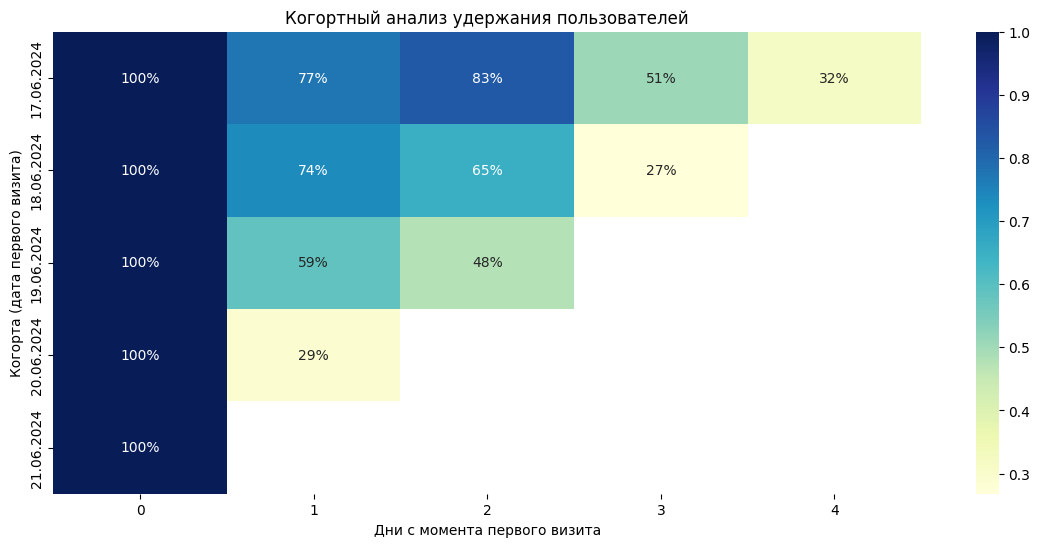

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Приводим индекс к дате без времени
retention_percent.index = pd.to_datetime(retention_percent.index).strftime('%d.%m.%Y')

plt.figure(figsize=(14, 6))
sns.heatmap(retention_percent, annot=True, fmt='.0%', cmap='YlGnBu')
plt.title('Когортный анализ удержания пользователей')
plt.xlabel('Дни с момента первого визита')
plt.ylabel('Когорта (дата первого визита)')
plt.show()


### Динамика активностей

In [18]:
## Статистика по активностям
users_activities_count=df.groupby(['event_type']).agg(event_type_count=('event_type','count')).reset_index()
users_activities_count

,event_type,event_type_count
0,adds,213648
1,clicks,535927
2,views,27006473


In [19]:
## Статистика по активностям по дням
users_activities=df.groupby(['dt','event_type']).agg(event_type_count=('event_type','count')).reset_index()
users_activities

,dt,event_type,event_type_count
0,2024-06-17,adds,36988
1,2024-06-17,clicks,49189
2,2024-06-17,views,3096944
3,2024-06-18,adds,37599
4,2024-06-18,clicks,132083
5,2024-06-18,views,6098293
6,2024-06-19,adds,71225
7,2024-06-19,clicks,178680
8,2024-06-19,views,9004922
9,2024-06-20,adds,34034


In [20]:
# Фильтруем данные по каждому типу действия
clicks_data = users_activities[users_activities['event_type'] == 'clicks']
adds_data = users_activities[users_activities['event_type'] == 'adds']
views_data = users_activities[users_activities['event_type'] == 'views']

# Функция для построения графика
def plot_interactive(data, title):
    fig = px.line(
        data,
        x='dt',
        y='event_type_count',
        color='event_type',
        markers=True,
        title=title,
        labels={'dt': 'Дата', 'event_type_count': 'Количество событий'}
    )
    fig.update_layout(
        xaxis_tickangle=-45,
        hovermode='x unified',
        template='plotly_white'
    )
    fig.update_xaxes(
    tickformat='%Y-%m-%d'  # форматирование только даты
    )
    fig.show()

# Строим графики для каждого типа действия
plot_interactive(views_data, 'Динамика просмотров пользователями')
plot_interactive(clicks_data, 'Динамика кликов пользователей')
plot_interactive(adds_data, 'Динамика добавлений товаров в корзину')


### User-based конверсия

In [21]:
# Подсчитаем количество уникальных клиентов для каждого типа действия (views, clicks, adds)
views_users = df[df['event_type'] == 'views']['client_id'].nunique()
clicks_users = df[df['event_type'] == 'clicks']['client_id'].nunique()
adds_users = df[df['event_type'] == 'adds']['client_id'].nunique()

# Считаем количество пользователей на каждом этапе
total_views = views_users
total_clicks = clicks_users
total_adds = adds_users

# Вычислим проценты перехода
views_to_clicks_percent = (total_clicks / total_views) * 100 if total_views > 0 else 0
clicks_to_adds_percent = (total_adds / total_clicks) * 100 if total_clicks > 0 else 0
views_to_adds_percent = (total_adds / total_views) * 100 if total_views > 0 else 0

# Данные для воронки
funnel_data = pd.DataFrame({
    'Стадия': ['Просмотры', 'Клики', 'Добавления в корзину'],
    'Пользователи': [total_views, total_clicks, total_adds]
})

# Построение воронки
fig = px.funnel(funnel_data, x='Пользователи', y='Стадия', title='Воронка конверсий (по пользователям)')

# Легенда с цифрами и конверсиями
legend_text = (
    f"<b>Этапы воронки:</b><br>"
    f"Просмотры: {total_views}<br>"
    f"Клики: {total_clicks}<br>"
    f"Добавления в корзину: {total_adds}<br><br>"
    f"<b>Конверсии:</b><br>"
    f"Просмотры → Клики: {views_to_clicks_percent:.1f}%<br>"
    f"Клики → Корзина: {clicks_to_adds_percent:.1f}%<br>"
    f"Просмотры → Корзина: {views_to_adds_percent:.1f}%"
)

# Параметры позиции аннотации (можно менять)
legend_x = 0.05   # по оси X (0 — слева, 1 — справа, можно и за границей)
legend_y = 0.05    # по оси Y (0 — низ, 1 — верх)

fig.add_annotation(
    text=legend_text,
    xref="paper", yref="paper",
    x=legend_x, y=legend_y,
    showarrow=False,
    align="left",
    font=dict(size=14),
    bordercolor="#c7c7c7",
    borderwidth=1,
    borderpad=10,
    bgcolor="white",
    opacity=0.9
)

fig.show()


### Event-based конверсия

In [22]:
# Подсчитаем общее количество событий каждого типа
total_views = df[df['event_type'] == 'views'].shape[0]
total_clicks = df[df['event_type'] == 'clicks'].shape[0]
total_adds = df[df['event_type'] == 'adds'].shape[0]

# Считаем event-based конверсии
views_to_clicks_percent = (total_clicks / total_views) * 100 if total_views > 0 else 0
clicks_to_adds_percent = (total_adds / total_clicks) * 100 if total_clicks > 0 else 0
views_to_adds_percent = (total_adds / total_views) * 100 if total_views > 0 else 0

# Подготовка данных для воронки
funnel_data = pd.DataFrame({
    'Стадия': ['Просмотры', 'Клики', 'Добавления в корзину'],
    'События': [total_views, total_clicks, total_adds]
})

# Построение воронки
fig = px.funnel(funnel_data, x='События', y='Стадия', title='Воронка конверсий (по событиям)')

# Текст аннотации с event-based метриками
legend_text = (
    f"<b>Этапы воронки:</b><br>"
    f"Просмотры: {total_views:,}<br>"
    f"Клики: {total_clicks:,}<br>"
    f"Добавления в корзину: {total_adds:,}<br><br>"
    f"<b>Конверсии:</b><br>"
    f"Просмотры → Клики: {views_to_clicks_percent:.1f}%<br>"
    f"Клики → Корзина: {clicks_to_adds_percent:.1f}%<br>"
    f"Просмотры → Корзина: {views_to_adds_percent:.1f}%"
)

# Положение аннотации можно настраивать через legend_x / legend_y
legend_x = 0.05
legend_y = 0.05

fig.add_annotation(
    text=legend_text,
    xref="paper", yref="paper",
    x=legend_x, y=legend_y,
    showarrow=False,
    align="left",
    font=dict(size=14),
    bordercolor="#c7c7c7",
    borderwidth=1,
    borderpad=10,
    bgcolor="white",
    opacity=0.9
)

fig.show()


### Динамика конверсий по дням

In [23]:
# Считаем уникальных пользователей с хотя бы одним действием по дням
daily_summary = daily_activities_by_unclietns.groupby('dt').agg({
    'views':'sum',
    'clicks': 'sum',
    'adds': 'sum'
}).reset_index()

# Вычисляем конверсии
daily_summary['views_to_clicks'] = daily_summary['clicks'] / daily_summary['views'] * 100
daily_summary['clicks_to_adds'] = daily_summary['adds'] / daily_summary['clicks'] * 100
daily_summary['views_to_adds'] = daily_summary['adds'] / daily_summary['views'] * 100

# Построим график
fig = px.line(
    daily_summary,
    x='dt',
    y=['views_to_clicks', 'clicks_to_adds', 'views_to_adds'],
    labels={
        'dt': 'Дата',
        'value': 'Конверсия (%)',
        'variable': 'Метрика'
    },
    title='Динамика конверсий по дням',
    markers=True
)

# Оформление
fig.update_layout(
    yaxis_title='Конверсия (%)',
    xaxis_title='Дата',
    legend_title='Тип конверсии',
    template='plotly_white',
    hovermode='x unified'
)
fig.update_xaxes(
    tickformat='%Y-%m-%d'  # форматирование только даты
)

fig.show()


### Распределение пользователей по кол-ву активностей

In [24]:
def plot_event_distribution_with_stats(df):
    # Считаем количество событий на пользователя по каждому типу
    user_event_counts = df.groupby(['client_id', 'event_type']).size().unstack(fill_value=0)

    # Убедимся, что все нужные колонки есть
    for col in ['views', 'clicks', 'adds']:
        if col not in user_event_counts.columns:
            user_event_counts[col] = 0

    # Построим графики по каждому типу событий
    for event in ['views', 'clicks', 'adds']:
        data = user_event_counts[event]

        # Вычисляем статистику
        mean_val = data.mean()
        median_val = data.median()
        min_val = data.min()
        max_val = data.max()
        std_val = data.std()

        # Создаём аннотацию
        stats_text = (
            f"<b>Статистика:</b><br>"
            f"Среднее: {mean_val:.2f}<br>"
            f"Медиана: {median_val}<br>"
            f"Макс: {max_val}<br>"
            f"Мин: {min_val}<br>"
            f"Ст. отклонение: {std_val:.2f}"
        )

        # Строим гистограмму
        fig = px.histogram(
            user_event_counts,
            x=event,
            nbins=50,
            title=f'Распределение пользователей по числу событий: {event}',
            labels={event: f'Количество {event}', 'count': 'Число пользователей'},
            template='plotly_white'
        )

        # Добавляем аннотацию на график
        fig.add_annotation(
            text=stats_text,
            xref="paper", yref="paper",
            x=0.98, y=0.98,
            showarrow=False,
            align="left",
            font=dict(size=13),
            bordercolor="#c7c7c7",
            borderwidth=1,
            borderpad=10,
            bgcolor="white",
            opacity=0.9
        )

        fig.update_layout(
            xaxis_title=f'Количество {event}',
            yaxis_title='Число пользователей',
            bargap=0.1
        )
        fig.show()
plot_event_distribution_with_stats(df)

Output hidden; open in https://colab.research.google.com to view.

###Выводы:
Основные характеристики пользователей представлены ниже:
Кол-во уникальных клиентов и DAU
Количество уникальных клиентов: 3 102 736
Среднее DAU: 1 655 725.8
Медианное DAU: 1 831 314.0

**Удержание клиентов (Retention rate)**

Когортный анализ удержания клиентов показывает, что до 70% теряется в течение первых 5 дней.
При этом каждая последующая когорта пользователей быстрее теряет интерес.

**Динамика активностей пользователей**

На 19.06.2024 приходится пик активности пользователей. В этот день совершено в разы больше добавлений товаров в корзину (70к) против 37к в остальные дни.
**User-based конверсия**
Конверсия в просмотр рекламы составляет 7,4%. Есть потенциал роста за счет подбора более таргетированных товаров, указанных в рекламе.
Целевая метрика - конверсия в добавление товара в корзину после просмотра рекламы равна 39,6%. После просмотра рекламы пользователи с хорошей конверсией добавляют товар в корзину.
**Event-based конверсия**
Конверсия в просмотр рекламы составляет 2,0%. Есть потенциал роста за счет подбора более таргетированных товаров, указанных в рекламе.
Целевая метрика - конверсия в добавление товара в корзину после просмотра рекламы равна 39,9%. После просмотра рекламы пользователи с хорошей конверсией добавляют товар в корзину.

**Вывод:** Для расчета целевой метрики мы будем использовать User-based конверсию, так как нам важно оценить поведение пользователей.

**Динамика конверсий по дням**

На 19.06.2024 целевая конверсия упала с 70% до 40%. В этот день наблюдалось большое кол-во пользователей при более низкой конверсии.

**Распределение пользователей по кол-ву активностей**

Большинство клиентов просмотрели главную страницу не более 30 раз.
Большинство клиентов просмотрели рекламу менее 3 раз.
Большинство клиентов добавили товары из рекламы в корзину менее 2 раз.

## Определение MDE и минимальный размер аудитории

1.   Ключевая метрика: CR = adds / clicks — конверсия из клика в добавление в корзину.
2.   Вспомогательная метрика: CTR = clicks / views — как пользователи реагируют на рекламу.



Это позволяет:

*   отслеживать, как вовлечение переходит в намерение купить
*   понять, действительно ли новое размещение влияет на результат, а не просто повышает клики без пользы





### Расчет ключевой метрики для каждого уникального пользователя

In [25]:
# Добавим булевы признаки: было ли событие у клиента в этот день
df['event_flag'] = 1

# Сводная таблица: по дню и клиенту, 1 если событие было, 0 если не было (определяем, было ли событие у клиента в тот или иной день)
event_presence = df.pivot_table(
    index=['dt', 'client_id'],
    columns='event_type',
    values='event_flag',
    aggfunc='max',  # если было хотя бы одно событие — будет 1
    fill_value=0
).reset_index()

# Убедимся, что все нужные столбцы есть
for col in ['views', 'clicks', 'adds']:
    if col not in event_presence.columns:
        event_presence[col] = 0

# Упорядочим столбцы
ordered_columns = ['dt', 'client_id', 'views', 'clicks', 'adds']
event_presence = event_presence[ordered_columns]

# Выводим результат
event_presence.head()

event_type,dt,client_id,views,clicks,adds
0,2024-06-17,1,1,0,0
1,2024-06-17,3,1,1,0
2,2024-06-17,19,1,0,0
3,2024-06-17,37,1,0,0
4,2024-06-17,41,1,0,0


In [26]:
# Группируем данные по client_id и суммируем события
user_summary = event_presence.groupby('client_id')[['views','clicks', 'adds']].sum().reset_index()

# Вычисляем CR: добавления в корзину / клики
user_summary['CR'] = user_summary.apply(
    lambda row: row['adds'] / row['clicks'] if row['clicks'] > 0 else None,
    axis=1
)

# Посмотрим на результат
user_summary.head()


event_type,client_id,views,clicks,adds,CR
0,1,2,0,0,NaN
1,3,4,3,1,0.333333
2,4,4,0,0,NaN
3,19,4,0,0,NaN
4,27,2,0,0,NaN


### Определение дисперсии и среднего значения целевой метрики (CR)

In [27]:
#Нужно расчитать выборочное среднее и дисперсию
#Используем дельта-метод для расчета дисперсии, если у нас ratio-метрика (ниже)
def var_ratio(x,y): #x/y
    mean_x = np.mean(x)      # Среднее по adds
    mean_y = np.mean(y)      # Среднее по clicks
    var_x = np.var(x, ddof=1)  # Выборочная дисперсия adds
    var_y = np.var(y, ddof=1)  # Выборочная дисперсия clicks
    cov_xy = np.cov(x, y, ddof=1)[0][1]  # Ковариация между adds и clicks
    result = var_x/mean_y**2 + var_y*mean_x**2/mean_y**4 - 2*mean_x*cov_xy/mean_y**3
    return result
#Тут x,y - это дисперсии величин

In [28]:
# Импортируем numpy
import numpy as np

# Берём массивы x = adds, y = clicks
x = user_summary['adds'].values
y = user_summary['clicks'].values

# Оставляем только те строки, где клики > 0 (иначе CR не определена)
mask = y > 0
x = x[mask]
y = y[mask]

# Вычисляем среднее и дисперсию с помощью дельта-метода
mean_cr = np.mean(x / y)
var_cr = var_ratio(x, y)

print(f"Среднее значение CR: {mean_cr:.4f}")
print(f"Дисперсия CR (дельта-метод): {var_cr:.6f}")

Среднее значение CR: 0.4443
Дисперсия CR (дельта-метод): 0.334631


### Определение MDE (минимальный наблюдаемый эффект)

In [29]:
from scipy import stats
# минимальный наблюдаемый эффект
def get_MDE(mu, std, sample_size, n_groups=2, target_share=0.5, r=1, alpha=0.05, beta=0.2):
    """Возвращает MDE для обычной пользовательской метрики, при заданных параметрах теста.
                                    ТАРГЕТНЫЕ ГРУППЫ ДОЛЖНЫ БЫТЬ РАВНЫ
    mu: float, среднее выборки на исторических данных
    std: float, стан. отклонение выборки на исторических данных
    sample size: int, размер выборки для теста (включает в себя все группы)
    n_groups: int, количество групп в тесте с учетом всех контрольных и таргетных
    target_share: float, доля одной таргетной группы
    r: float, отношение самой маленькой группы к самой большой группе
    alpha: float, уровень ошибки I рода
    beta: float, уровень ошибки II рода

    return: MDE abs и MDE в %
    """

    t_alpha = stats.norm.ppf(1 - ((alpha / 2)), loc=0, scale=1)
    comparisons = n_groups - 1
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    sample_ratio_correction = r+2+1/r

    mde = np.sqrt(sample_ratio_correction)*(t_alpha + t_beta) * std / np.sqrt(
        sample_size*(1-target_share*(comparisons-1)))
    # mde = np.sqrt((r+1)/r)*(t_alpha + t_beta) * std / np.sqrt(sample_size/n_groups)

    return mde, mde*100/mu

In [113]:
total_clients = len(user_summary)  # всего уникальных клиентов
test_sample_size = int(total_clients * 0.0395)  # размер выборки для теста (включает в себя все группы) составляет 3,95% от аудитории
total_clients

3102736

In [114]:
# Расчет MDE
mde_abs, mde_pct = get_MDE(mean_cr, np.sqrt(var_cr), test_sample_size)

# Вывод результата в формате пояснения
print(f"Минимальный эффект, который A/B-тест сможет с высокой вероятностью обнаружить — это изменение конверсии (CR) на {mde_abs:.4f} в абсолюте.")
print(f"Это означает, что для заданных параметров теста мы можем уловить не менее чем ~{mde_pct:.2f}% относительное изменение метрики.")


Минимальный эффект, который A/B-тест сможет с высокой вероятностью обнаружить — это изменение конверсии (CR) на 0.0093 в абсолюте.
Это означает, что для заданных параметров теста мы можем уловить не менее чем ~2.08% относительное изменение метрики.


### Определение минимального размера выборки

In [115]:
# минимальный размер аудитории
def get_sample_size(mu, var, mde, r=1, alpha=0.05, beta=0.2):
    """Возвращает минимальный размер аудитории для обычной пользовательской метрики
        при заданных параметрах теста
    mu: float, среднее выборки на исторических данных
    var: float, дисперсия выборки на исторических данных
    mde: float, минимальный эффект
    r: float, отношение самой маленькой группы к самой большой группе
    alpha: float, уровень ошибки I рода
    beta: float, уровень ошибки II рода

    return: размер аудитории для одной группы
    """

    t_alpha = stats.norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)

    sample_size = (r+1) / r * var * (t_alpha + t_beta)**2 / (mde*mu)**2
    # sample_size = (r+1) / r * var * (t_alpha + t_beta)**2 / (mde)**2 # mde abs

    return sample_size

In [116]:
# Расчет минимального размера аудитории
sample_size = get_sample_size (mean_cr, var_cr, mde_abs)

# Вывод результата в формате пояснения
print(f"Минимальный размер аудитории для проведения А/Б теста: {sample_size:.1f} .")
print(f"Минимальный размер аудитории для проведения А/Б теста в % от кол-ва уникальных клиентов: {(sample_size / total_clients) * 100:.2f} %.")

Минимальный размер аудитории для проведения А/Б теста: 310420.6 .
Минимальный размер аудитории для проведения А/Б теста в % от кол-ва уникальных клиентов: 10.00 %.


### Выводы:
Для проведения теста необходимо определить размер аудитории, на которой будет проводиться тест.
Для проведения теста будет сформированы 2 гомогенные группы одинакового размера (тестовая и контрольная группы).
Минимальный размер аудитории зависит от MDE, который мы хотим заметить при проведении теста. Чем ниже MDE, тем большая аудитория должна быть задействована в тесте, чтобы желаемый эффект был обнаружен.
Мы не хотим привлекать большую аудиторию  для тестирования, чтобы ограничить возможные негативные эффекты, в случае если гипотеза является неверной.
Поэтому максимальный размер аудитории мы устанавливаем в размере 20% от уникального количества пользователей.

Результат расчета:
Чтобы добиться максимальной задействованной аудитории в 20%, нам нужно зафиксировать минимальный эффект, который A/B-тест сможет с высокой вероятностью обнаружить — это изменение конверсии (CR) на 0.0093 в абсолюте.
Это означает, что для заданных параметров теста мы можем уловить не менее чем ~2.08% относительное изменение метрики.
При этом Минимальный размер аудитории для одной группы при проведении А/Б теста составит 310 420.6 .
Минимальный размер аудитории для проведения для одной группы при проведении А/Б теста в % от кол-ва уникальных пользователей составит 10.00 %.

## Анализ результатов А/Б теста

### Структура данных результата теста

In [34]:
dr=pd.read_excel('/content/drive/MyDrive/Обучение Zerocoder Data Scientist/Final project/final_results_to_analyze.xlsx')
dr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981510 entries, 0 to 981509
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            981510 non-null  datetime64[ns]
 1   client_id       981510 non-null  int64         
 2   ab_group        981510 non-null  object        
 3   is_view_ads     981510 non-null  int64         
 4   cnt_view_ads    981510 non-null  int64         
 5   is_adds_ads     981510 non-null  int64         
 6   cnt_adds_ads    981510 non-null  int64         
 7   sum_adds_ads    981510 non-null  int64         
 8   is_orders_ads   981510 non-null  int64         
 9   cnt_orders_ads  981510 non-null  int64         
 10  sum_orders_ads  981510 non-null  int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 82.4+ MB


In [35]:
dr.head()

,date,client_id,ab_group,is_view_ads,cnt_view_ads,is_adds_ads,cnt_adds_ads,sum_adds_ads,is_orders_ads,cnt_orders_ads,sum_orders_ads
0,2024-07-26,8881380,test,0,0,0,0,0,0,0,0
1,2024-07-28,850950385,test,0,0,0,0,0,0,0,0
2,2024-07-25,50885,control,0,0,0,0,0,0,0,0
3,2024-07-26,601239,control,0,0,0,0,0,0,0,0
4,2024-07-28,694655866,control,0,0,0,0,0,0,0,0


In [36]:
dr.describe()

,date,client_id,is_view_ads,cnt_view_ads,is_adds_ads,cnt_adds_ads,sum_adds_ads,is_orders_ads,cnt_orders_ads,sum_orders_ads
count,981510,9.815100e+05,981510.000000,981510.000000,981510.000000,981510.000000,981510.000000,981510.000000,981510.000000,981510.000000
mean,2024-07-27 00:18:44.024818944,1.708445e+08,0.052206,0.088918,0.014411,0.032741,5.082794,0.012481,0.011676,3.339542
min,2024-07-24 00:00:00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2024-07-25 00:00:00,1.143451e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2024-07-27 00:00:00,9.681953e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2024-07-29 00:00:00,8.993345e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2024-07-30 00:00:00,9.688485e+08,1.000000,28.000000,1.000000,26.000000,5809.000000,1.000000,5.000000,5809.000000
std,NaN,3.023737e+08,0.222443,0.475500,0.119180,0.350391,57.082421,0.111018,0.138554,45.843918


#### Проверка на дубликаты

In [37]:
duplicates_count = dr.duplicated().sum()

if duplicates_count > 0:
    print(f'Количество дубликатов: {duplicates_count}')
else:
    print('Дубликаты отсутствуют')

Количество дубликатов: 6486


In [38]:
dr=dr.drop_duplicates()
dr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 975024 entries, 0 to 981509
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            975024 non-null  datetime64[ns]
 1   client_id       975024 non-null  int64         
 2   ab_group        975024 non-null  object        
 3   is_view_ads     975024 non-null  int64         
 4   cnt_view_ads    975024 non-null  int64         
 5   is_adds_ads     975024 non-null  int64         
 6   cnt_adds_ads    975024 non-null  int64         
 7   sum_adds_ads    975024 non-null  int64         
 8   is_orders_ads   975024 non-null  int64         
 9   cnt_orders_ads  975024 non-null  int64         
 10  sum_orders_ads  975024 non-null  int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 89.3+ MB


#### Проверка на пропуски

In [39]:
# Проверка пропусков
missing = dr.isnull().sum()
if missing.sum() == 0:
    print("Пропусков нет")
else:
    print("Пропуски найдены в следующих столбцах:")
    print(missing[missing > 0])

Пропусков нет


#### Приведение дат к формату datetime

In [40]:
#привести дату к типу datetime
dr['date'] = pd.to_datetime(dr['date'])

####  Анализ количества уникальных клиентов в тестовой и контрольной группах. Удаление пересечений

In [41]:
print(f"Минимальный эффект, который A/B-тест сможет с высокой вероятностью обнаружить — это изменение конверсии (CR) на {mde_abs:.4f} в абсолюте.")
print(f"Минимальный размер аудитории для проведения А/Б теста: {sample_size:.1f} .")

Минимальный эффект, который A/B-тест сможет с высокой вероятностью обнаружить — это изменение конверсии (CR) на 0.0093 в абсолюте.
Минимальный размер аудитории для проведения А/Б теста: 310420.6 .


In [42]:
# Количество уникальных клиентов в контрольной и тестовой группах
nunique_clients_control=dr[dr['ab_group']=='control']['client_id'].nunique()
print(f'Количество уникальных клиентов в контрольной группе (группа А): {nunique_clients_control}')
nunique_clients_test=dr[dr['ab_group']=='test']['client_id'].nunique()
print(f'Количество уникальных клиентов в тестовой группе (группа Б): {nunique_clients_test}')

Количество уникальных клиентов в контрольной группе (группа А): 200786
Количество уникальных клиентов в тестовой группе (группа Б): 200474


In [43]:
# Проверка на пересечение клиентов в контрольнйо и тестовой группах

# Получаем уникальные client_id для каждой группы
clients_control = dr[dr['ab_group'] == 'control']['client_id'].unique()
clients_test = dr[dr['ab_group'] == 'test']['client_id'].unique()

# Преобразуем в множества
set_control = set(clients_control)
set_test = set(clients_test)

# Пересечение
intersection = set_control.intersection(set_test)

# Выводим результат
print(f"Количество клиентов, попавших в обе группы: {len(intersection)}")


Количество клиентов, попавших в обе группы: 6393


In [44]:
# Удаляем пересекающихся клиентов из датафрейма
dr_cleaned = dr[~dr['client_id'].isin(intersection)]

# Проверим результат
print(f"Размер очищенного датафрейма: {dr_cleaned.shape}")
print(f"Количество удалённых клиентов: {len(intersection)}")

Размер очищенного датафрейма: (940417, 11)
Количество удалённых клиентов: 6393


In [45]:
# Количество уникальных клиентов в контрольной и тестовой группах после удаления пересечений
nunique_clients_control_cleaned=dr_cleaned[dr_cleaned['ab_group']=='control']['client_id'].nunique()
print(f'Количество уникальных клиентов в контрольной группе: {nunique_clients_control_cleaned}')
nunique_clients_test_cleaned=dr_cleaned[dr_cleaned['ab_group']=='test']['client_id'].nunique()
print(f'Количество уникальных клиентов в тестовой группе: {nunique_clients_test_cleaned}')

Количество уникальных клиентов в контрольной группе: 194393
Количество уникальных клиентов в тестовой группе: 194081


In [46]:
# Сравниваем количество уникальных клиентов в контрольной группе и тестовой группах с рассчитанной минимальной аудиторией
print(f'Контрольная группа составляет: {nunique_clients_control_cleaned/sample_size*100:.1f}% от минимальной аудитории, необходимой для проведения теста')
print(f'Тестовая группа составляет: {nunique_clients_test_cleaned/sample_size*100:.1f}%, необходимой для проведения теста')

Контрольная группа составляет: 62.6% от минимальной аудитории, необходимой для проведения теста
Тестовая группа составляет: 62.5%, необходимой для проведения теста


#### Выводы:
Исходные данные содержат 981 510 строк и 11 столбцов.
При анализе данных  было обнаружено и удалено 6 486 дубликатов.
Пропусков в исходных данных не обнаружено.
Количество уникальных клиентов в контрольной группе (группа А): 200 786.
Количество уникальных клиентов в тестовой группе (группа Б): 200 474.
Для корректного анализа результатов теста была проведена проверка на пересечение клиентов в контрольной и тестовой группах.
Количество клиентов, попавших в обе группы: 6 393. Клиенты, входящие в обе группы, были удалены.

**Результат расчета:**
Количество уникальных клиентов в контрольной группе: 194 393
Количество уникальных клиентов в тестовой группе: 194 081
Контрольная группа составляет: 62.6% от минимальной аудитории, необходимой для проведения теста.
Тестовая группа составляет: 62.5%, необходимой для проведения теста.

**Проведенный тест не охватывает достаточной аудитории, чтобы обнаружить желаемый MDE.**


### Анализ метрик в контрольной и тестовой группах и определение статистической значимости полученных результатов (расчет конверсий ведется по клиентам и дням)

#### Расчет ключевых и вспомогательных метрик

In [47]:
# 1. Группировка по клиенту и дате
daily_agg = dr_cleaned.groupby(['client_id', 'ab_group', 'date']).agg({
    'is_view_ads': 'max',
    'cnt_view_ads': 'sum',
    'is_adds_ads': 'max',
    'cnt_adds_ads': 'sum',
    'sum_adds_ads': 'sum',
    'is_orders_ads': 'max',
    'cnt_orders_ads': 'sum',
    'sum_orders_ads': 'sum'
}).reset_index()
daily_agg

,client_id,ab_group,date,is_view_ads,cnt_view_ads,is_adds_ads,cnt_adds_ads,sum_adds_ads,is_orders_ads,cnt_orders_ads,sum_orders_ads
0,2,test,2024-07-25,0,0,0,0,0,0,0,0
1,2,test,2024-07-26,0,0,0,0,0,0,0,0
2,2,test,2024-07-29,0,0,0,0,0,0,0,0
3,3,control,2024-07-24,0,0,0,0,0,0,0,0
4,3,control,2024-07-26,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
939731,968833683,test,2024-07-30,0,0,0,0,0,0,0,0
939732,968834625,test,2024-07-30,0,0,0,0,0,0,0,0
939733,968839461,test,2024-07-30,0,0,0,0,0,0,0,0
939734,968845834,control,2024-07-30,0,0,0,0,0,0,0,0


In [48]:
# Разделяем на группы
control = daily_agg[daily_agg['ab_group'] == 'control']
test = daily_agg[daily_agg['ab_group'] == 'test']

# Функция для расчёта расширенных метрик на клиент-день
def calculate_daily_metrics_extended(df):
    clients_days = df[['client_id', 'date']].drop_duplicates().shape[0]
    unique_clients = df['client_id'].nunique()

    total_orders = df['cnt_orders_ads'].sum()
    total_adds = df['cnt_adds_ads'].sum()
    total_orders_sum = df['sum_orders_ads'].sum()
    total_adds_sum = df['sum_adds_ads'].sum()

    return {
        'clients_days': clients_days,
        'unique_clients': unique_clients,
        'CR_click_to_add': df['is_adds_ads'].sum() / df['is_view_ads'].sum(),
        'avg_adds_per_click': df['cnt_adds_ads'].sum() / df['cnt_view_ads'].sum(),
        'avg_adds_sum_per_click': df['sum_adds_ads'].sum() / df['cnt_adds_ads'].sum(),
        'CR_add_to_order': df['is_orders_ads'].sum() / df['is_adds_ads'].sum(),
        'avg_orders_per_add': total_orders / total_adds,
        'avg_check': total_orders_sum / total_orders,
        'avg_orders_per_client_day': total_orders / clients_days,
        'avg_orders_per_client': total_orders / unique_clients,
        'purchase_rate': total_orders_sum / total_adds_sum,
        'ARPU': total_orders_sum / unique_clients,
    }

# Применим к обеим группам
metrics_control_daily = calculate_daily_metrics_extended(control)
metrics_test_daily = calculate_daily_metrics_extended(test)

# Вывод
print("Метрики по контрольной группе (по клиент-день):")
for k, v in metrics_control_daily.items():
    print(f"{k}: {v:.4f}")

print("\nМетрики по тестовой группе (по клиент-день):")
for k, v in metrics_test_daily.items():
    print(f"{k}: {v:.4f}")


Метрики по контрольной группе (по клиент-день):
clients_days: 469132.0000
unique_clients: 194393.0000
CR_click_to_add: 0.2813
avg_adds_per_click: 0.3675
avg_adds_sum_per_click: 155.5650
CR_add_to_order: 0.8754
avg_orders_per_add: 0.3597
avg_check: 284.9419
avg_orders_per_client_day: 0.0117
avg_orders_per_client: 0.0283
purchase_rate: 0.6588
ARPU: 8.0546

Метрики по тестовой группе (по клиент-день):
clients_days: 470604.0000
unique_clients: 194081.0000
CR_click_to_add: 0.2773
avg_adds_per_click: 0.3785
avg_adds_sum_per_click: 154.4740
CR_add_to_order: 0.8863
avg_orders_per_add: 0.3658
avg_check: 286.9392
avg_orders_per_client_day: 0.0123
avg_orders_per_client: 0.0299
purchase_rate: 0.6795
ARPU: 8.5868


#### Расчёт uplift и статистической значимости

In [49]:
# Улучшенная функция для t-теста с обработкой edge cases
def t_test_means(sample1, sample2):
    # Удаляем NaN и бесконечные значения
    sample1 = sample1.replace([np.inf, -np.inf], np.nan).dropna()
    sample2 = sample2.replace([np.inf, -np.inf], np.nan).dropna()

    # Проверяем, что осталось достаточно данных
    if len(sample1) < 2 or len(sample2) < 2:
        return np.nan, np.nan

    # Проверяем на нулевую дисперсию
    if np.std(sample1) == 0 and np.std(sample2) == 0:
        return 0.0, 1.0  # Если все значения одинаковые в обеих группах

    try:
        t_stat, p_val = stats.ttest_ind(sample1, sample2, equal_var=False)
        return t_stat, p_val
    except:
        return np.nan, np.nan

# Улучшенная функция для z-теста пропорций
def z_test_proportions(success_a, size_a, success_b, size_b):
    # Проверка edge cases
    if size_a == 0 or size_b == 0:
        return np.nan, np.nan

    p1 = success_a / size_a
    p2 = success_b / size_b

    # Если пропорции одинаковые
    if p1 == p2:
        return 0.0, 1.0

    p_pool = (success_a + success_b) / (size_a + size_b)
    se = np.sqrt(p_pool * (1 - p_pool) * (1/size_a + 1/size_b))
    z = (p2 - p1) / se
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    return z, p_value

# Функция для безопасного деления (защита от деления на 0)
def safe_divide(a, b):
    return np.divide(a, b, out=np.zeros_like(a), where=b!=0)

# Пересчитываем все метрики с обработкой edge cases
results = {}

# 1. CR клик → добавление
z1, p1 = z_test_proportions(
    control['is_adds_ads'].sum(), control['is_view_ads'].sum(),
    test['is_adds_ads'].sum(), test['is_view_ads'].sum()
)
results['CR клик → добавление'] = (z1, p1)

# 2. CR добавление → заказ
z2, p2 = z_test_proportions(
    control['is_orders_ads'].sum(), control['is_adds_ads'].sum(),
    test['is_orders_ads'].sum(), test['is_adds_ads'].sum()
)
results['CR добавление → заказ'] = (z2, p2)

# 3. Purchase rate (используем безопасное деление)
orders_control = control['sum_orders_ads'].sum()
adds_control = control['sum_adds_ads'].sum()
orders_test = test['sum_orders_ads'].sum()
adds_test = test['sum_adds_ads'].sum()

if adds_control > 0 and adds_test > 0:
    z3, p3 = z_test_proportions(orders_control, adds_control, orders_test, adds_test)
else:
    z3, p3 = np.nan, np.nan
results['Процент выкупа корзины'] = (z3, p3)

#Средние значения – t-тесты с безопасным делением
#4. Добавлений / клик
t1, pt1 = t_test_means(
    safe_divide(control['cnt_adds_ads'], control['cnt_view_ads']),
    safe_divide(test['cnt_adds_ads'], test['cnt_view_ads'])
)
results['Добавление в корзину/ Показ рекламы'] = (t1, pt1)

#5. Средний чек товаров в корзине
t2, pt2 = t_test_means(
    safe_divide(control['sum_adds_ads'], control['cnt_adds_ads']),
    safe_divide(test['sum_adds_ads'], test['cnt_adds_ads'])
)
results['Средний чек товаров в корзине'] = (t2, pt2)

#6. Заказов / добавление
t3, pt3 = t_test_means(
    safe_divide(control['cnt_orders_ads'], control['cnt_adds_ads']),
    safe_divide(test['cnt_orders_ads'], test['cnt_adds_ads'])
)
results['Заказ / Добавление в корзину'] = (t3, pt3)

#7. Средний чек
t5, pt5 = t_test_means(
    safe_divide(control['sum_orders_ads'], control['cnt_orders_ads']),
    safe_divide(test['sum_orders_ads'], test['cnt_orders_ads'])
)
results['Средний чек'] = (t5, pt5)

#8. Заказы на клиента в день
t6, pt6 = t_test_means(
    control.groupby(['client_id', 'date'])['cnt_orders_ads'].sum(),
    test.groupby(['client_id', 'date'])['cnt_orders_ads'].sum()
)
results['Заказов на клиент в день'] = (t6, pt6)

#9. Заказы на клиента
t7, pt7 = t_test_means(
    control.groupby('client_id')['cnt_orders_ads'].sum(),
    test.groupby('client_id')['cnt_orders_ads'].sum()
)
results['Заказов на клиента'] = (t7, pt7)

#10. Выручка на клиента
t7, pt7 = t_test_means(
    control.groupby('client_id')['sum_orders_ads'].sum(),
    test.groupby('client_id')['sum_orders_ads'].sum()
)
results['Выручка на клиента'] = (t7, pt7)

# Вывод результатов с цветовой маркировкой
print("{:<40} {:<15} {:<15} {:<10}".format("Метрика", "Z/T-статистика", "p-value", "Значимость"))
print("-" * 80)

for metric, (stat, p_val) in results.items():
    if np.isnan(stat) or np.isnan(p_val):
        signif = "❌ Нет данных"
    elif p_val < 0.01:
        signif = "✅✅ Высокая значимость"
    elif p_val < 0.05:
        signif = "✅ Значимо"
    elif p_val < 0.1:
        signif = "⚠️ Пограничная значимость"
    else:
        signif = "❌ Не значимо"

    stat_fmt = f"{stat:.4f}" if not np.isnan(stat) else "nan"
    pval_fmt = f"{p_val:.4f}" if not np.isnan(p_val) else "nan"

    print("{:<40} {:<15} {:<15} {:<10}".format(
        metric, stat_fmt, pval_fmt, signif))

/usr/local/lib/python3.11/dist-packages/pandas/core/series.py:1031: RuntimeWarning:

invalid value encountered in cast



Метрика                                  Z/T-статистика  p-value         Значимость
--------------------------------------------------------------------------------
CR клик → добавление                     -0.9868         0.3238          ❌ Не значимо
CR добавление → заказ                    1.9788          0.0478          ✅ Значимо 
Процент выкупа корзины                   48.4790         0.0000          ✅✅ Высокая значимость
Добавление в корзину/ Показ рекламы      -0.9034         0.3663          ❌ Не значимо
Средний чек товаров в корзине            0.0641          0.9489          ❌ Не значимо
Заказ / Добавление в корзину             0.1151          0.9084          ❌ Не значимо
Средний чек                              -1.2022         0.2293          ❌ Не значимо
Заказов на клиент в день                 -2.1650         0.0304          ✅ Значимо 
Заказов на клиента                       -2.0348         0.0419          ✅ Значимо 
Выручка на клиента                       -1.9956         0

#### Таблица сравнения метрик

In [50]:
# Метрики из ранее рассчитанных словарей
metrics_control = metrics_control_daily
metrics_test = metrics_test_daily

# Таблица результатов
summary = pd.DataFrame([
    {
        'Метрика': 'CR клик → добавление',
        'Control': metrics_control['CR_click_to_add'],
        'Test': metrics_test['CR_click_to_add'],
        'Uplift, %': 100 * (metrics_test['CR_click_to_add'] - metrics_control['CR_click_to_add']) / metrics_control['CR_click_to_add'],
        'Z/T-статистика': z1,
        'P-value': p1,
        'Стат. значимость': "✅" if p1 < 0.05 else "⚠️",
        'Тип теста': 'z-test'
    },
    {
        'Метрика': 'CR добавление → заказ',
        'Control': metrics_control['CR_add_to_order'],
        'Test': metrics_test['CR_add_to_order'],
        'Uplift, %': 100 * (metrics_test['CR_add_to_order'] - metrics_control['CR_add_to_order']) / metrics_control['CR_add_to_order'],
        'Z/T-статистика': z2,
        'P-value': p2,
        'Стат. значимость': "✅" if p2 < 0.05 else "⚠️",
        'Тип теста': 'z-test'
    },
    {
        'Метрика': 'Процент выкупа корзины',
        'Control': metrics_control['purchase_rate'],
        'Test': metrics_test['purchase_rate'],
        'Uplift, %': 100 * (metrics_test['purchase_rate'] - metrics_control['purchase_rate']) / metrics_control['purchase_rate'],
        'Z/T-статистика': z3,
        'P-value': p3,
        'Стат. значимость': "✅" if p3 < 0.05 else "⚠️",
        'Тип теста': 'z-test'
    },
    {
        'Метрика': 'Добавление в корзину/ Показ рекламы',
        'Control': metrics_control['avg_adds_per_click'],
        'Test': metrics_test['avg_adds_per_click'],
        'Uplift, %': 100 * (metrics_test['avg_adds_per_click'] - metrics_control['avg_adds_per_click']) / metrics_control['avg_adds_per_click'],
        'Z/T-статистика': t1,
        'P-value': pt1,
        'Стат. значимость': "✅" if pt1 < 0.05 else "⚠️",
        'Тип теста': 't-test'
    },
    {
        'Метрика': 'Средний чек товаров в корзине',
        'Control': metrics_control['avg_adds_sum_per_click'],
        'Test': metrics_test['avg_adds_sum_per_click'],
        'Uplift, %': 100 * (metrics_test['avg_adds_sum_per_click'] - metrics_control['avg_adds_sum_per_click']) / metrics_control['avg_adds_sum_per_click'],
        'Z/T-статистика': t2,
        'P-value': pt2,
        'Стат. значимость': "✅" if pt2 < 0.05 else "⚠️",
        'Тип теста': 't-test'
    },
    {
        'Метрика': 'Заказ / Добавление в корзину',
        'Control': metrics_control['avg_orders_per_add'],
        'Test': metrics_test['avg_orders_per_add'],
        'Uplift, %': 100 * (metrics_test['avg_orders_per_add'] - metrics_control['avg_orders_per_add']) / metrics_control['avg_orders_per_add'],
        'Z/T-статистика': t3,
        'P-value': pt3,
        'Стат. значимость': "✅" if pt3 < 0.05 else "⚠️",
        'Тип теста': 't-test'
    },
    {
        'Метрика': 'Средний чек',
        'Control': metrics_control['avg_check'],
        'Test': metrics_test['avg_check'],
        'Uplift, %': 100 * (metrics_test['avg_check'] - metrics_control['avg_check']) / metrics_control['avg_check'],
        'Z/T-статистика': t5,
        'P-value': pt5,
        'Стат. значимость': "✅" if pt5 < 0.05 else "⚠️",
        'Тип теста': 't-test'
    },
    {
        'Метрика': 'Заказов на клиента в день',
        'Control': metrics_control['avg_orders_per_client_day'],
        'Test': metrics_test['avg_orders_per_client_day'],
        'Uplift, %': 100 * (metrics_test['avg_orders_per_client_day'] - metrics_control['avg_orders_per_client_day']) / metrics_control['avg_orders_per_client_day'],
        'Z/T-статистика': t6,
        'P-value': pt6,
        'Стат. значимость': "✅" if pt6 < 0.05 else "⚠️",
        'Тип теста': 't-test'
    },
    {
        'Метрика': 'Заказов на клиента',
        'Control': metrics_control['avg_orders_per_client'],
        'Test': metrics_test['avg_orders_per_client'],
        'Uplift, %': 100 * (metrics_test['avg_orders_per_client'] - metrics_control['avg_orders_per_client']) / metrics_control['avg_orders_per_client'],
        'Z/T-статистика': t7,
        'P-value': pt7,
        'Стат. значимость': "✅" if pt7 < 0.05 else "⚠️",
        'Тип теста': 't-test'
    },
    {
        'Метрика': 'Выручка на клиента',
        'Control': metrics_control['ARPU'],
        'Test': metrics_test['ARPU'],
        'Uplift, %': 100 * (metrics_test['ARPU'] - metrics_control['ARPU']) / metrics_control['ARPU'],
        'Z/T-статистика': t7,
        'P-value': pt7,
        'Стат. значимость': "✅" if pt7 < 0.05 else "⚠️",
        'Тип теста': 't-test'
    }
])

# Округляем
summary[['Control', 'Test', 'Uplift, %', 'Z/T-статистика', 'P-value']] = summary[
    ['Control', 'Test', 'Uplift, %', 'Z/T-статистика', 'P-value']
].round(4)

# Вывод
summary


,Метрика,Control,Test,"Uplift, %",Z/T-статистика,P-value,Стат. значимость,Тип теста
0,CR клик → добавление,0.2813,0.2773,-1.4208,-0.9868,0.3238,⚠️,z-test
1,CR добавление → заказ,0.8754,0.8863,1.2509,1.9788,0.0478,✅,z-test
2,Процент выкупа корзины,0.6588,0.6795,3.1512,48.4790,0.0000,✅,z-test
3,Добавление в корзину/ Показ рекламы,0.3675,0.3785,3.0098,-0.9034,0.3663,⚠️,t-test
4,Средний чек товаров в корзине,155.5650,154.4740,-0.7013,0.0641,0.9489,⚠️,t-test
5,Заказ / Добавление в корзину,0.3597,0.3658,1.7148,0.1151,0.9084,⚠️,t-test
6,Средний чек,284.9419,286.9392,0.7009,-1.2022,0.2293,⚠️,t-test
7,Заказов на клиента в день,0.0117,0.0123,5.3655,-2.1650,0.0304,✅,t-test
8,Заказов на клиента,0.0283,0.0299,5.8660,-1.9956,0.0460,✅,t-test
9,Выручка на клиента,8.0546,8.5868,6.6081,-1.9956,0.0460,✅,t-test


#### Выводы:
При анализе итогов А/Б теста было выявлено, что рассчитать все метрики согласно дизайну теста не представляется возможным ввиду отсутствия необходимых данных: количество просмотров главной страницы. Поэтому из анализа были исключены метрики:
Кликабельность секции рекламы (CTR) = количество кликов / количество просмотров главной страницы
Конверсия в заказ от просмотра главной страницы
После расчета метрик был рассчитан uplift каждой метрики и определена статистическая значимость изменений по каждой метрике.
При определении статистической значимости для конверсионных метрик (CR клик → добавление, CR добавление → заказ, Процент выкупа корзины) применялся z-test.
При определении статистической значимости для метрик, основанных на средних значениях (Добавление в корзину/ Показ рекламы, Средний чек товаров в корзине, Заказ / Добавление в корзину, Средний чек, Заказов на клиент в день, Заказов на клиента, Выручка на клиента(ARPU)) применялся t-test.

**Вывод:**
Ключевая метрика CR клик → добавление за время проведения не прокрасилась. Разница метрики в контрольной и тестовой группах статистически не значима.
А/Б тест не выявил значимой статистической разницы по ключевой метрики не может считаться успешным. Так как изначально была выявлена недостаточность в выборке теста, предлагается продолжить тестирование, чтобы набрать минимальную аудиторию для выявления MDE.
При этом изменения в вспомогательных метриках (CR добавление → заказ, Процент выкупа корзины, Заказов на клиента в день, Заказов на клиента, Выручка на клиента) оказались статистически значимы.


### Динамика изменения исходных показателей и разница в тестовой и контрольных группах

In [51]:
# 1. Агрегация по группе
base_metrics = daily_agg.groupby('ab_group').agg({
    'cnt_view_ads': 'sum',
    'cnt_adds_ads': 'sum',
    'sum_adds_ads': 'sum',
    'cnt_orders_ads': 'sum',
    'sum_orders_ads': 'sum',
    'client_id': pd.Series.nunique  # уникальные клиенты в день
}).reset_index().rename(columns={'client_id': 'unique_clients'})
base_metrics

,ab_group,cnt_view_ads,cnt_adds_ads,sum_adds_ads,cnt_orders_ads,sum_orders_ads,unique_clients
0,control,41576,15278,2376722,5495,1565756,194393
1,test,41941,15876,2452430,5808,1666543,194081


In [52]:
# 1. Агрегация по группе и дате
grouped_daily = daily_agg.groupby(['ab_group', 'date']).agg({
    'cnt_view_ads': 'sum',
    'cnt_adds_ads': 'sum',
    'sum_adds_ads': 'sum',
    'cnt_orders_ads': 'sum',
    'sum_orders_ads': 'sum',
    'client_id': pd.Series.nunique  # уникальные клиенты в день
}).reset_index().rename(columns={'client_id': 'unique_clients'})

# 2. Сортировка по дате внутри группы
grouped_daily = grouped_daily.sort_values(by=['ab_group', 'date'])

# 3. Добавление накопительных сумм
metrics_to_cumsum = ['cnt_view_ads', 'cnt_adds_ads', 'sum_adds_ads', 'cnt_orders_ads', 'sum_orders_ads']
for metric in metrics_to_cumsum:
    grouped_daily[f'cumsum_{metric}'] = grouped_daily.groupby('ab_group')[metric].cumsum()

# 4. Среднее количество заказов на клиента в день
grouped_daily['avg_orders_per_client'] = grouped_daily['cnt_orders_ads'] / grouped_daily['unique_clients']

# 5. Настройки для построения графиков
metric_plot_config = {
    'cumsum_cnt_view_ads': 'кол-во кликов (накопительно)',
    'cumsum_cnt_adds_ads': 'кол-во добавлений в корзину (накопительно)',
    'cumsum_sum_adds_ads': 'сумма товаров в корзине (накопительно)',
    'cumsum_cnt_orders_ads': 'кол-во заказов  (накопительно)',
    'cumsum_sum_orders_ads': 'сумма заказов  (накопительно)',
    'avg_orders_per_client': 'Среднее кол-во заказов на клиента в день'
}

# 6. Визуализация графиков
for col, label in metric_plot_config.items():
    fig = px.line(
        grouped_daily,
        x='date',
        y=col,
        color='ab_group',
        markers=True,
        title=label,
        labels={'date': 'Дата', col: label, 'ab_group': 'Группа'}
    )

    fig.update_layout(height=400)
    fig.show()

In [53]:
# 1. Преобразуем данные в широкий формат (pivot)
pivoted = grouped_daily.pivot(index='date', columns='ab_group', values=list(metric_plot_config.keys()))

# 2. Вычисляем относительную разницу (test - control) / control * 100%
for metric in metric_plot_config.keys():
    pivoted[('rel_diff', metric)] = (pivoted[(metric, 'test')] - pivoted[(metric, 'control')]) / pivoted[(metric, 'control')] * 100

# 3. Собираем данные для визуализации
rel_diff_data = pivoted['rel_diff'].reset_index().melt(id_vars='date',
                                                      value_vars=list(metric_plot_config.keys()),
                                                      var_name='metric',
                                                      value_name='relative_diff')

# 4. Создаем понятные названия метрик
metric_names = {k: v for k, v in metric_plot_config.items()}
rel_diff_data['metric_name'] = rel_diff_data['metric'].map(metric_names)

# 5. Визуализация с легендой внизу
fig = px.line(rel_diff_data,
              x='date',
              y='relative_diff',
              color='metric_name',
              markers=True,
              title='Относительная разница между тестовой и контрольной группами (%)',
              labels={'date': 'Дата',
                     'relative_diff': 'Относительная разница (%)',
                     'metric_name': 'Метрика'})

fig.update_layout(
    height=600,
    hovermode='x unified',
    yaxis_title="Разница, %",
    legend_title='Метрики',
    legend=dict(
        orientation="h",  # горизонтальное расположение
        yanchor="bottom", # якорь внизу
        y=-0.2,           # отступ ниже графика
        xanchor="center",  # центрирование по горизонтали
        x=0.5             # центр по оси X
    )
)

# Добавляем горизонтальную линию на уровне 0
fig.add_hline(y=0, line_dash="dash", line_color="red")

fig.show()

### Динамика изменения ключевых показателей

In [54]:
# 1. Функция для расчёта метрик на каждый день
def compute_daily_metrics(df):
    metrics_list = []

    for (group, date), group_df in df.groupby(['ab_group', 'date']):
        clients_days = group_df[['client_id', 'date']].drop_duplicates().shape[0]
        unique_clients = group_df['client_id'].nunique()

        total_orders = group_df['cnt_orders_ads'].sum()
        total_adds = group_df['cnt_adds_ads'].sum()
        total_orders_sum = group_df['sum_orders_ads'].sum()
        total_adds_sum = group_df['sum_adds_ads'].sum()
        total_views = group_df['cnt_view_ads'].sum()
        is_views = group_df['is_view_ads'].sum()
        is_adds = group_df['is_adds_ads'].sum()
        is_orders = group_df['is_orders_ads'].sum()

        metrics_list.append({
            'ab_group': group,
            'date': date,
            'CR_click_to_add': is_adds / is_views if is_views > 0 else 0,
            'avg_adds_per_click': total_adds / total_views if total_views > 0 else 0,
            'avg_adds_sum_per_click': total_adds_sum / total_adds if total_adds > 0 else 0,
            'CR_add_to_order': is_orders / is_adds if is_adds > 0 else 0,
            'avg_orders_per_add': total_orders / total_adds if total_adds > 0 else 0,
            'avg_check': total_orders_sum / total_orders if total_orders > 0 else 0,
            'avg_orders_per_client_day': total_orders / clients_days if clients_days > 0 else 0,
            'avg_orders_per_client': total_orders / unique_clients if unique_clients > 0 else 0,
            'purchase_rate': total_orders_sum / total_adds_sum if total_adds_sum > 0 else 0,
            'ARPU': total_orders_sum / unique_clients if unique_clients > 0 else 0
        })

    return pd.DataFrame(metrics_list)

# 2. Считаем метрики по дням
daily_metrics = compute_daily_metrics(daily_agg)
daily_metrics

,ab_group,date,CR_click_to_add,avg_adds_per_click,avg_adds_sum_per_click,CR_add_to_order,avg_orders_per_add,avg_check,avg_orders_per_client_day,avg_orders_per_client,purchase_rate,ARPU
0,control,2024-07-24,0.268608,0.353239,157.273053,0.889376,0.354508,286.196532,0.010744,0.010744,0.645114,3.074945
1,control,2024-07-25,0.290581,0.379226,159.235104,0.884729,0.354273,295.032595,0.012225,0.012225,0.656400,3.606847
2,control,2024-07-26,0.283030,0.363989,158.648596,0.879874,0.377057,286.930680,0.010108,0.010108,0.681943,2.900245
3,control,2024-07-27,0.276155,0.348389,156.931996,0.877823,0.374266,277.256209,0.014363,0.014363,0.661227,3.982145
4,control,2024-07-28,0.280998,0.367802,155.120734,0.885291,0.367747,281.163573,0.011132,0.011132,0.666559,3.129930
5,control,2024-07-29,0.285504,0.388337,151.848471,0.848297,0.346874,275.656579,0.009741,0.009741,0.629693,2.685127
6,control,2024-07-30,0.283981,0.370927,151.089428,0.861111,0.345787,291.880460,0.015481,0.015481,0.668005,4.518595
7,test,2024-07-24,0.288726,0.385274,158.147111,0.887050,0.364000,285.989011,0.012670,0.012670,0.658248,3.623362
8,test,2024-07-25,0.274104,0.374108,153.038608,0.887354,0.366063,287.289062,0.012304,0.012304,0.687185,3.534732
9,test,2024-07-26,0.274081,0.381769,156.838298,0.888179,0.377305,278.471178,0.010291,0.010291,0.669916,2.865617


In [55]:
# Сопоставление технических названий с читаемыми (русскими)
metric_labels = {
    'CR_click_to_add': 'CR клик → добавление',
    'avg_adds_per_click': 'Добавление в корзину/ Показ рекламы',
    'avg_adds_sum_per_click': 'Средний чек товаров в корзине',
    'CR_add_to_order': 'CR добавление → заказ',
    'avg_orders_per_add': 'Заказ / Добавление в корзину',
    'avg_check': 'Средний чек',
    'avg_orders_per_client_day': 'Заказов на клиента в день',
    'avg_orders_per_client': 'Заказов на клиента',
    'purchase_rate': 'Процент выкупа товаров',
    'ARPU': 'Выручка на клиента'
}

# Функция для визуализации с подписями данных
def plot_all_metrics(df, metric_labels, group_col='ab_group', date_col='date'):
    for metric, label in metric_labels.items():
        fig = px.line(
            df,
            x=date_col,
            y=metric,
            color=group_col,
            markers=True,
            text=df[metric].round(4),
            title=label
        )
        fig.update_traces(textposition="top center")
        fig.update_layout(
            title=dict(text=label, x=0.5),
            xaxis_title="Дата",
            yaxis_title=label,
            legend_title="Группа",
            hovermode="x unified"
        )
        fig.show()

# Вызов функции
plot_all_metrics(daily_metrics, metric_labels)


In [56]:
# 1. Разделим на контроль и тест
control = daily_metrics[daily_metrics['ab_group'] == 'control'].copy()
test = daily_metrics[daily_metrics['ab_group'] == 'test'].copy()

# 2. Объединяем по дате
merged = pd.merge(
    test, control,
    on='date',
    suffixes=('_test', '_control')
)

# 3. Список метрик
metrics = [
    'CR_click_to_add',
    'avg_adds_per_click',
    'avg_adds_sum_per_click',
    'CR_add_to_order',
    'avg_orders_per_add',
    'avg_check',
    'avg_orders_per_client_day',
    'avg_orders_per_client',
    'purchase_rate',
    'ARPU'
]

# 4. Расчёт относительного изменения
for metric in metrics:
    merged[f'rel_change_{metric}'] = (
        merged[f'{metric}_test'] / merged[f'{metric}_control'] - 1
    )

# 5. Вывод таблицы изменений
rel_change_cols = ['date'] + [f'rel_change_{m}' for m in metrics]
relative_changes = merged[rel_change_cols]
relative_changes


,date,rel_change_CR_click_to_add,rel_change_avg_adds_per_click,rel_change_avg_adds_sum_per_click,rel_change_CR_add_to_order,rel_change_avg_orders_per_add,rel_change_avg_check,rel_change_avg_orders_per_client_day,rel_change_avg_orders_per_client,rel_change_purchase_rate,rel_change_ARPU
0,2024-07-24,0.074897,0.090689,0.005558,-0.002615,0.026775,-0.000725,0.179205,0.179205,0.020359,0.178350
1,2024-07-25,-0.056703,-0.013494,-0.038914,0.002967,0.033281,-0.026246,0.006421,0.006421,0.046900,-0.019994
2,2024-07-26,-0.031621,0.048848,-0.011411,0.009439,0.000657,-0.029483,0.018076,0.018076,-0.017635,-0.011940
3,2024-07-27,-0.032422,0.036418,-0.019896,0.016952,-0.021815,0.009018,-0.017208,-0.017208,0.007043,-0.008345
4,2024-07-28,-0.006181,0.055479,0.004963,0.015504,0.015076,0.021000,0.103448,0.103448,0.031274,0.126621
5,2024-07-29,0.012370,0.033258,-0.006576,0.028990,0.050144,0.034033,0.103425,0.103425,0.093071,0.140978
6,2024-07-30,-0.058058,-0.029225,0.011325,0.016449,0.015273,0.038812,-0.003443,-0.003443,0.042867,0.035235


In [57]:
# Названия метрик для отображения
metric_labels = {
    'CR_click_to_add': 'CR клик → добавление',
    'avg_adds_per_click': 'Добавление в корзину/ Показ рекламы',
    'avg_adds_sum_per_click': 'Средний чек товаров в корзине',
    'CR_add_to_order': 'CR добавление → заказ',
    'avg_orders_per_add': 'Заказ / Добавление в корзину',
    'avg_check': 'Средний чек',
    'avg_orders_per_client_day': 'Заказов на клиента в день',
    'avg_orders_per_client': 'Заказов на клиента',
    'purchase_rate': 'Процент выкупа товаров',
    'ARPU': 'Выручка на клиента'
}

# Построим графики по каждой метрике
for metric, label in metric_labels.items():
    fig = px.line(
        relative_changes,
        x='date',
        y=f'rel_change_{metric}',
        title=f'Относительное изменение: {label} (Тест / Контроль − 1)',
        markers=True,
        labels={f'rel_change_{metric}': 'Изменение'}
    )

    # Добавим подписи значений
    fig.update_traces(text=relative_changes[f'rel_change_{metric}'].apply(lambda x: f"{x:.1%}"),
                      textposition="top center")

    fig.update_layout(
        yaxis_tickformat=".1%",
        xaxis_title='Дата',
        yaxis_title='Изменение, %',
        height=400
    )

    fig.show()


### Выводы:

1. В тестовой и контрольной группах снизилась конверсия в добавление товаров в корзину после просмотра рекламы по сравнению с исходными данными с 39,9% до 27,7% и 28,1% соответственно. При этом конверсия  в добавление товаров в корзину после просмотра рекламы при event-based подходе осталась примерно на том же уровне - 37,9% и 36,8% соответственно. Можно сделать вывод о том, что доля пользователей, готовых купить товар после просмотра рекламы снизилась, а активность таких людей (кол-во кликов и добавление товара в корзину) выросла.
2. Конверсия в покупку после добавления товара в корзину составляет 88,6% и 87,5% для тестовой и контрольной групп соответственно. Конверсия в покупку после добавления товаров в корзину при event-based подходе равна 36,6% и 36,0% для тестовой и контрольной групп соответственно. Можно сделать вывод о том, что большинство пользователей делает одну покупку после добавления товара в корзину. Однако, вероятность последующих покупок после добавления товара в корзину резко падает. При этом процент выкупа корзины (по стоимости товаров) составляет - 67,9% и 65,9%, что говорит о том, что пользователи чаще отказываются от покупки товаров, добавленных в корзину, с более низким средним чеком.
3. Средний чек товаров в корзине составляет 154,5 и 155,6 у.е. для тестовой и контрольной групп соответственно. Средний чек в заказе составляет 286,9 и 284,9 у.е. соответственно. Средний чек в заказе выше среднего чека корзины, что подтверждает выводы из п. 2.
4. Среднее количество заказов на клиента - 0,0299 и 0,0283 соответственно
5. Выручка на клиента	(ARPU) - 8,59 и 8,05 у.е.
6. Практически по всем показателям (клики, добавление в корзину, кол-во заказов, сумма заказов, сумма товаров в корзине) тестовая группа обогнала контрольную.


## Заключение

Перед нами стояла задача проверка гипотезы, что изменение размещения рекламы на странице маркетплейса влияет на взаимодействие пользователей с рекламой. Проверка гипотезы осуществлялась через проведение А/Б теста. Расчеты и визуализация проводились в notebook Google Collab (на языке Python). При этом были использованы библиотеки: pandas, numpy, plotly.express, seaborn, matplotlib.pyplot, scipy.stats.
Анализ результатов А/Б теста показал, что тест не выявил статистической значимости в разнице показателей контрольной и тестовой группы для целевой метрики CR клик → добавление. Кроме того, выборка кол-ва уникальных клиентов в тестовой и контрольных группах оказалась недостаточной (количество уникальных клиентов в контрольной группе (группа А): 200 786, количество уникальных клиентов в тестовой группе (группа Б): 200 474 при расчетной минимальной аудитории в 310 42,.6).
Требуется продолжение проведения тестирования, так как проведенный тест не охватывает достаточной аудитории, чтобы обнаружить желаемый MDE.
Из предложенных вспомогательных метрик, CR добавление → заказ, Процент выкупа корзины, Заказов на клиента в день, Заказов на клиента, Выручка на клиента оказались статистически значимы.